In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [2]:
test_images = glob.glob('test_images/test*')
calibration_images = glob.glob('camera_cal/calibration*.jpg')

def compare_images(images, mult=3, plot=None):
    img_count = len(images)
    fig, axs = plt.subplots(1,img_count, figsize=(mult*img_count, mult))

    i=0
    for title, img in images:
        try:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        except:
            pass
        axs[i].axis('off')
        axs[i].imshow(img.squeeze(), cmap='gray')
        axs[i].set_title(title, fontsize=14)
        i += 1
        
    if plot is not None:
        left_fit_x, right_fit_x = plot
        y_values = [y for y in range(721)]
        axs[1].set_xlim(0, 1280)
        axs[1].set_ylim(0, 720)
        axs[1].plot(left_fit_x, y_values, color='red', linewidth=3)
        axs[1].plot(right_fit_x, y_values, color='red', linewidth=3)

In [3]:
# 1. Distortion Correction

# prepare object points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

obj_points = [] # Real world 3D points
img_points = [] # "fake" 2d points

for img_path in calibration_images:
    img = cv2.imread(img_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(img_gray, (9,6))
    
    if ret:
        obj_points.append(objp)
        img_points.append(corners)

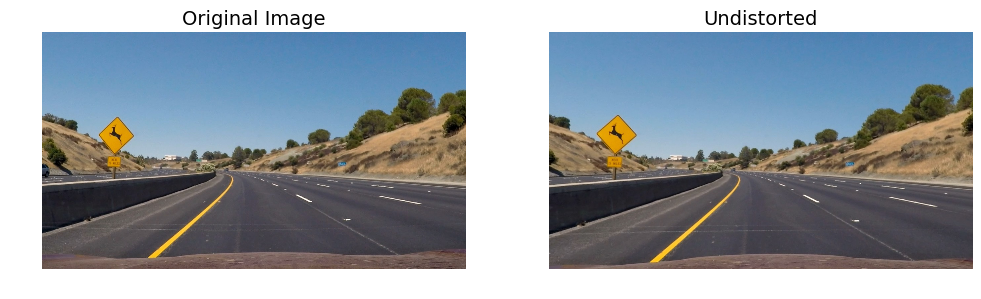

In [4]:
def undistort(img):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img.shape[1::-1], None, None)
    return cv2.undistort(img, mtx, dist, None, mtx)

img = cv2.imread(test_images[1])
img_undist = undistort(img)

compare_images([
    ('Original Image', img),
    ('Undistorted',    img_undist),
], 6)

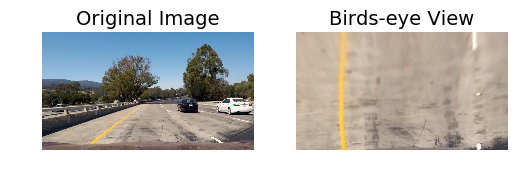

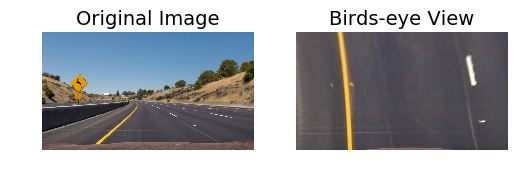

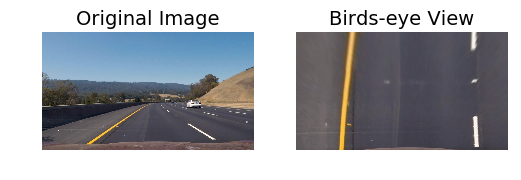

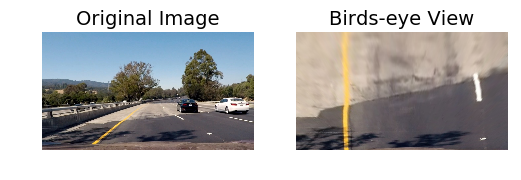

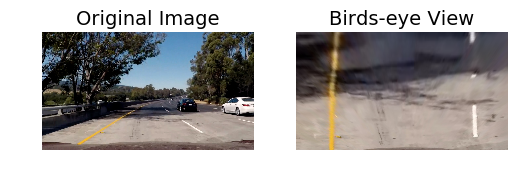

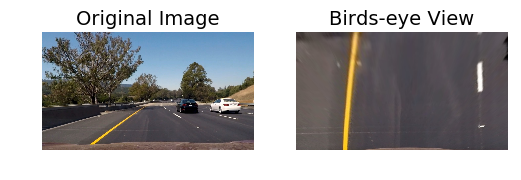

In [5]:
# 2. Perspective Transform

# define source and destination points for mapping
dst_persp = np.float32([
    [   0,   0], [1280,   0], 
    [1280, 720], [   0, 720]
])

def birds_eye(img):
    src_persp = np.float32([
        [ 490, 482], [810, 482],
        [1280, 690], [  0, 690]
    ])
    img_undist = undistort(img)
    M = cv2.getPerspectiveTransform(src_persp, dst_persp)
    return cv2.warpPerspective(img_undist, M, img.shape[1::-1]), M

def birds_eye_undo(img):
    src_persp = np.float32([
        [ 500, 482], [800, 482],
        [1240, 690], [ 40, 690]
    ])
    img_undist = undistort(img)
    M = cv2.getPerspectiveTransform(dst_persp, src_persp)
    return cv2.warpPerspective(img_undist, M, img.shape[1::-1]), M
    
for image in test_images:
    img = cv2.imread(image)
    img_birdseye, _ = birds_eye(img)
    
    compare_images([
        ('Original Image', img),
        ('Birds-eye View', img_birdseye),
    ])

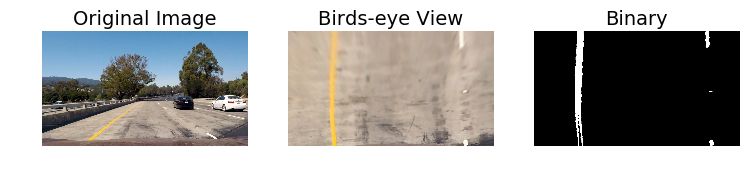

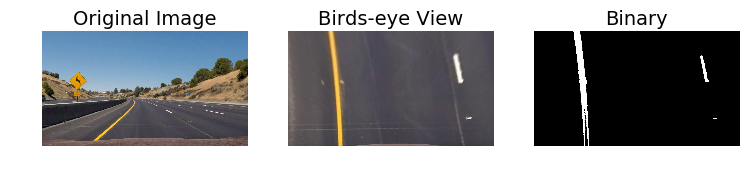

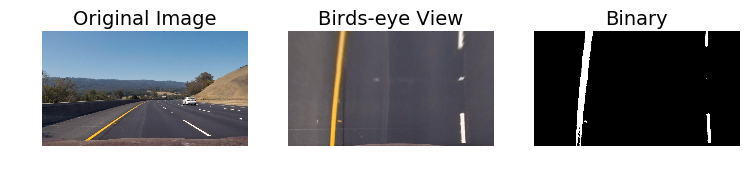

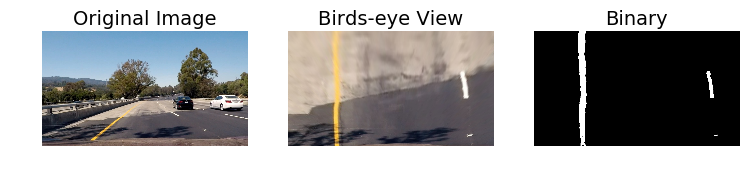

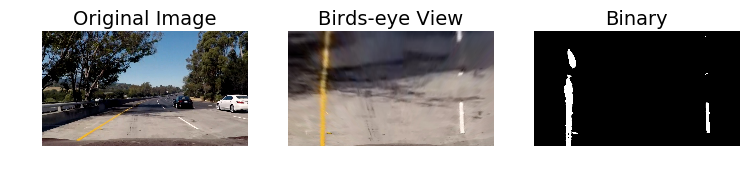

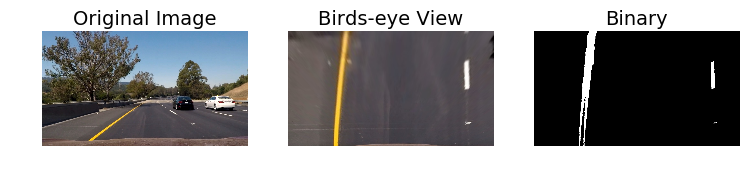

In [6]:
# Binary Thresholds
def binary_thresholded(img):
    img, _ = birds_eye(img)
    
    v_channel = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)[:,:,2]
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]
    
    def binary_thresholded_values(channel, min_threshold, max_threshold):
        binary = np.zeros_like(channel)
        binary[(channel >= min_threshold) & (channel <= max_threshold)] = 1
        return binary
    
    # tresholded binary output
    binary_v = binary_thresholded_values(v_channel, 185, 255)
    binary_b = binary_thresholded_values(b_channel, 155, 200)
    binary_l = binary_thresholded_values(l_channel, 225, 255)
    
    binary = np.zeros_like(binary_v)
    binary[(np.mean(img) < 55 and binary_v == 1) | (binary_b == 1) | (binary_l == 1)] = 1
    return binary, img

for img_path in test_images:
    img = cv2.imread(img_path)
    img_binary, img_birdseye = binary_thresholded(img)
    
    compare_images([
        ('Original Image', img),
        ('Birds-eye View', img_birdseye),
        ('Binary',         img_binary),
    ])

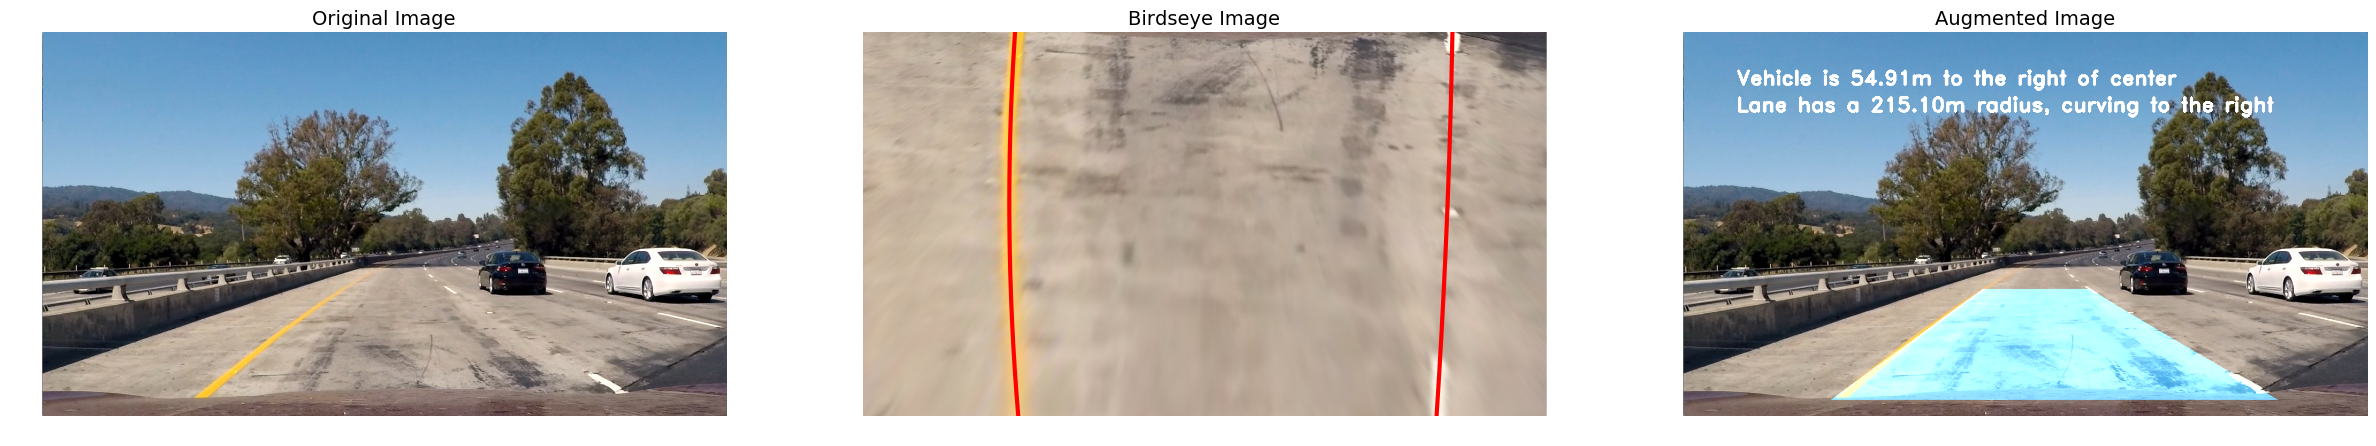

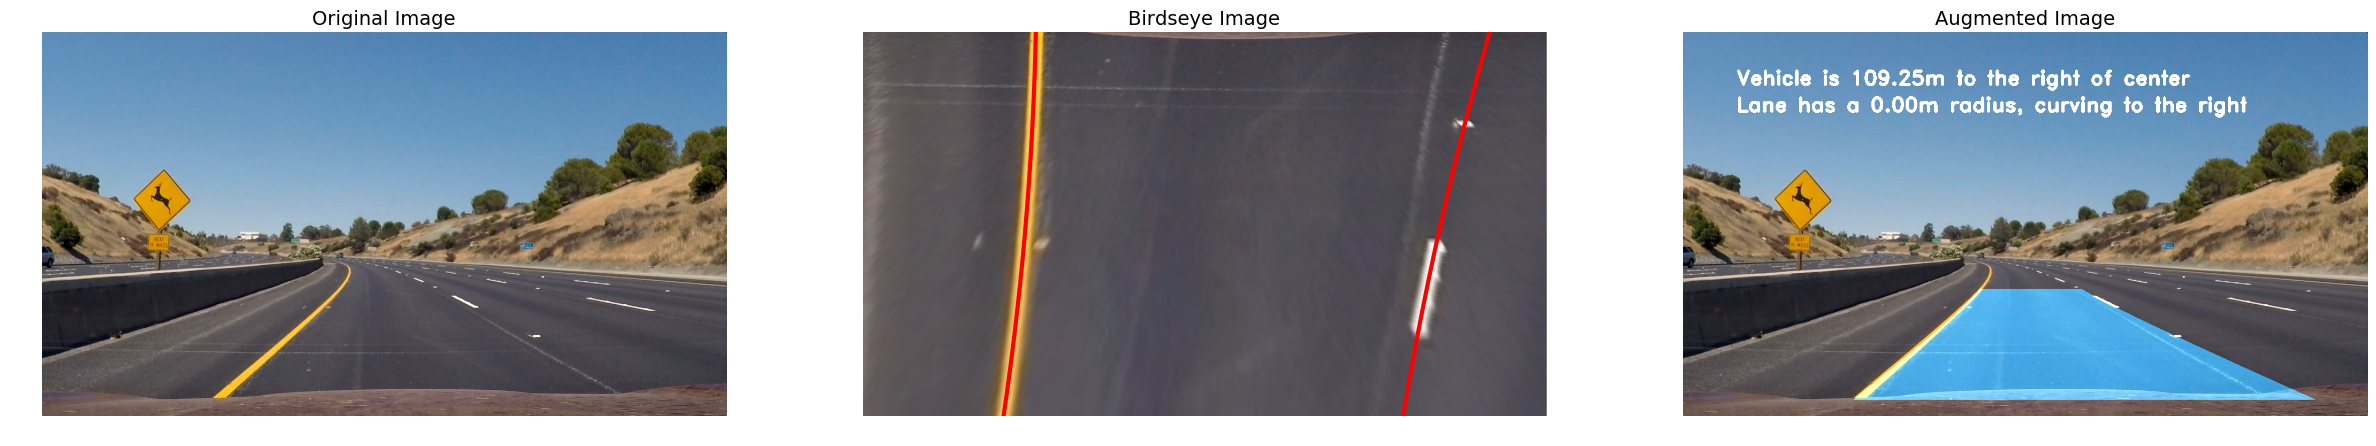

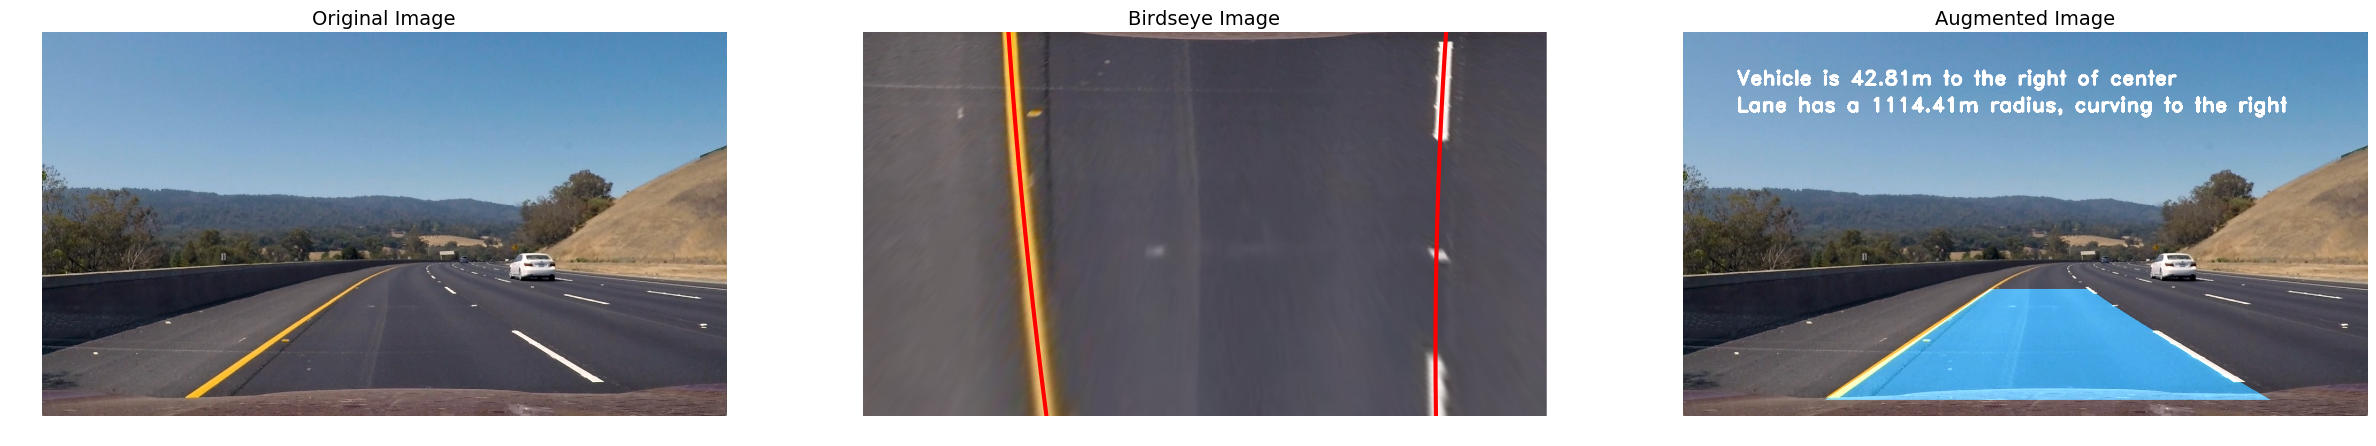

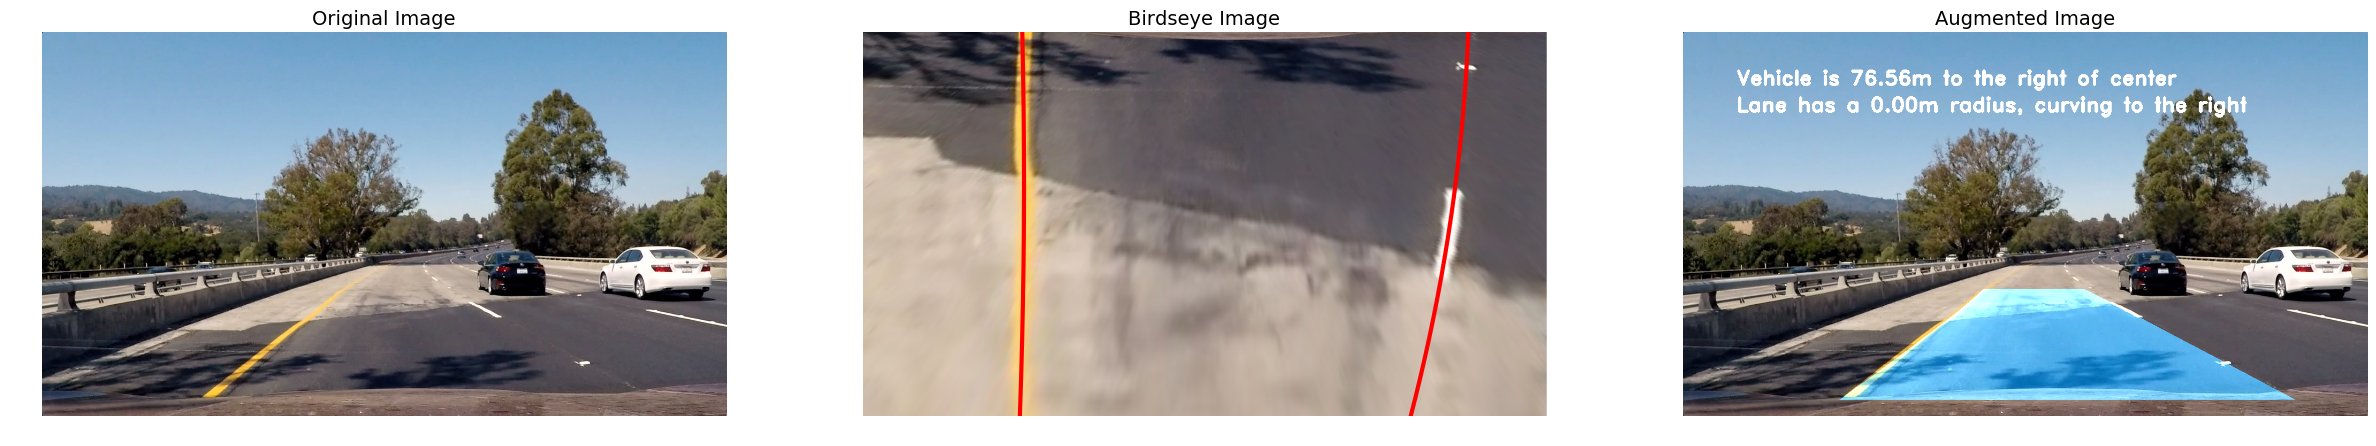

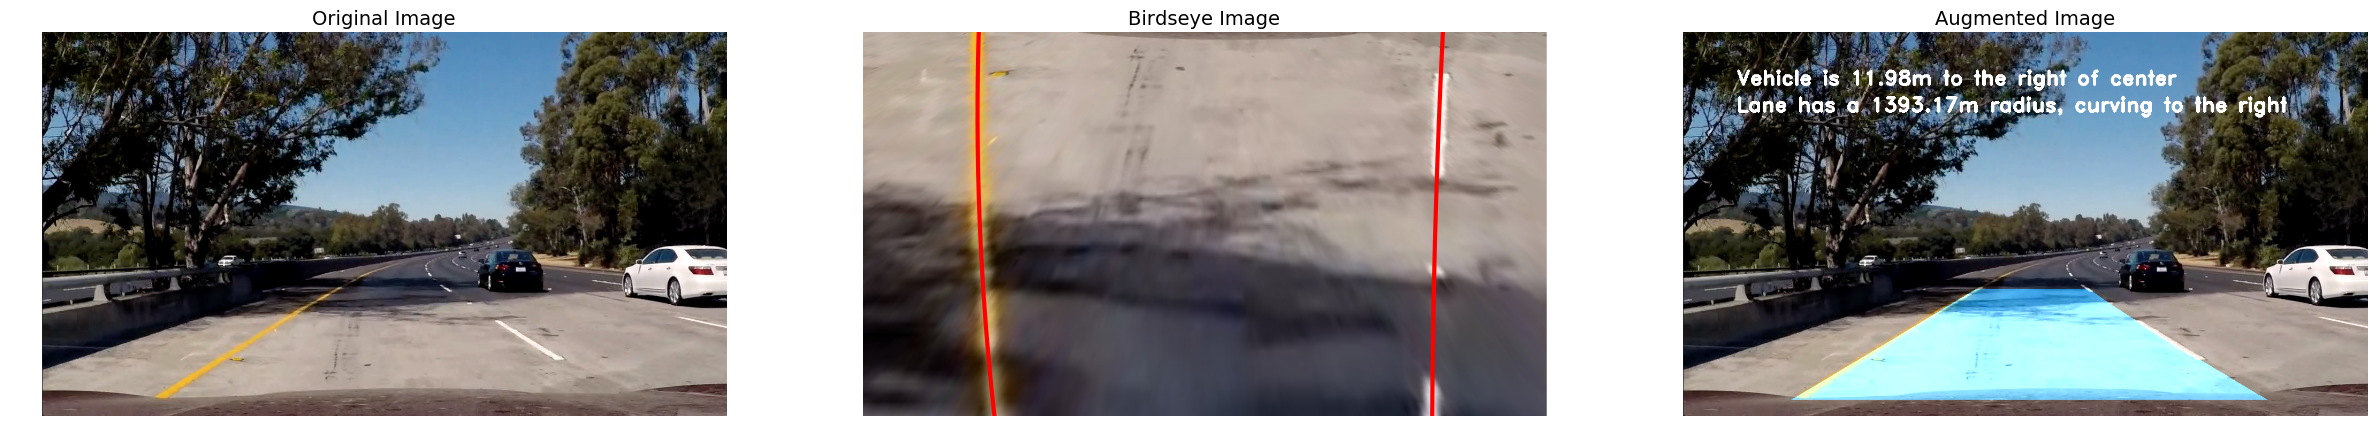

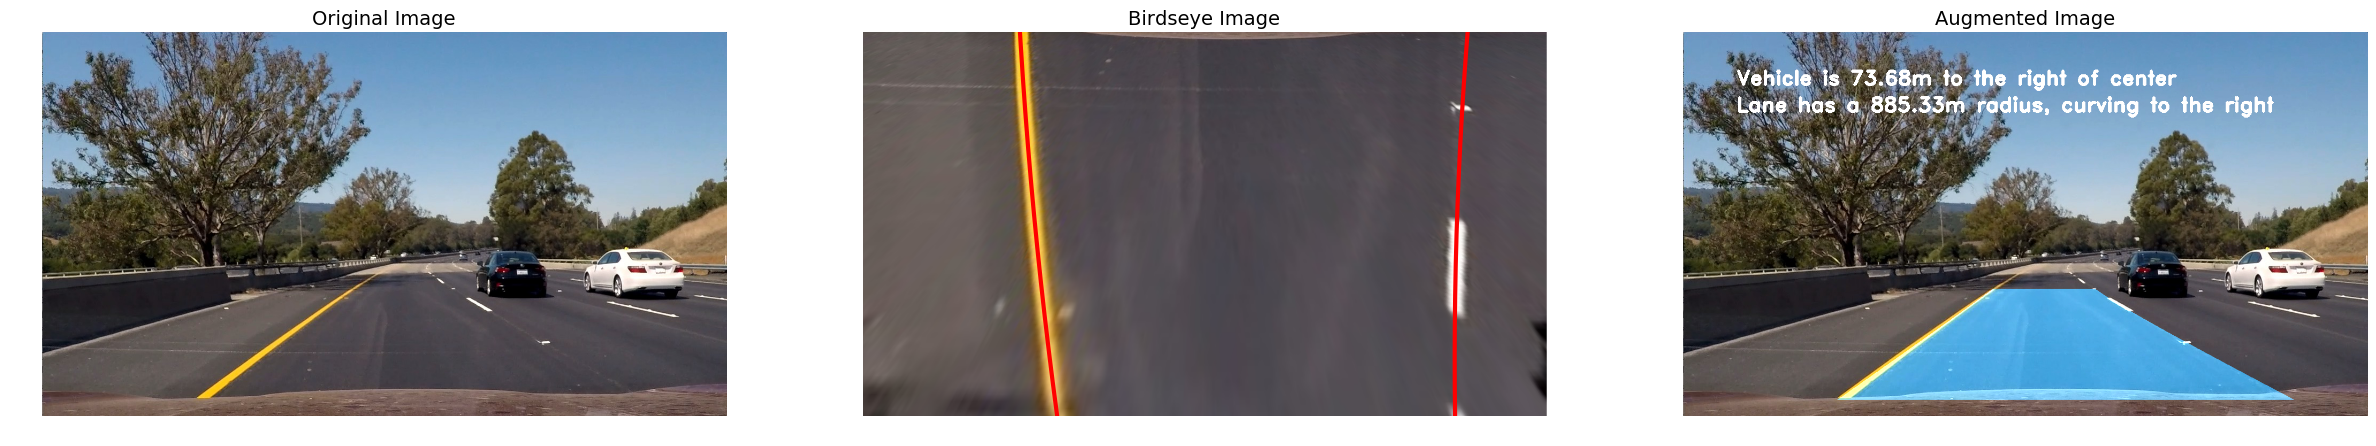

In [7]:
lane_width = 100
meters_per_px_y = 10/720.
meters_per_px_x = 5.5/1280

def get_line_points(binary, right_side=False):
    """
    Assumes binary image has one distinct line and returns the points associated with that line.
    Important to keep in mind that this function works with the transpose of the image. (x,y) are flipped
    """
    x, y = np.nonzero(np.transpose(binary))
    x_points = []
    y_points = []
    for bot in range(660,-1,-60):
        top = bot + 60
        histogram = np.sum(binary[bot:top,:], axis=0)
        if right_side:
            peak = np.argmax(histogram[640:]) + 640
        else:
            peak = np.argmax(histogram[:640])

        indexes = np.where(
            (x > peak - lane_width/2) &
            (x < peak + lane_width/2) &
            (y > bot)                 &
            (y < top)
        )
        if np.sum(x[indexes]) != 0:
            x_points.extend(x[indexes].tolist())
            y_points.extend(y[indexes].tolist())

    return np.asarray(x_points).astype(np.float32), np.asarray(y_points).astype(np.float32)

def get_line_func(x, y):
    fit = np.polyfit(y, x, 2)
    x = np.append(x, [
        fit[0]*720**2 + fit[1]*720 + fit[2],
        fit[2]
    ])
    y = np.append(y, [720, 0])
    
    sort_idxs = np.argsort(y)
    y = y[sort_idxs]
    x = x[sort_idxs]
    
    fit = np.polyfit(y, x, 2)
    return x, y, np.asarray([fit[0]*y**2 + fit[1]*y + fit[2] for y in range(721)]).astype(np.float32)

def get_roc(x, y):
    """http://mathworld.wolfram.com/RadiusofCurvature.html"""
    fit = np.polyfit(y*meters_per_px_y, x*meters_per_px_x, 2)
    dx_dy = 2 * fit[0] * np.mean(y) + fit[1]
    d2x_d2dy2 = 2 * fit[0]
    return ( (1 + dx_dy)**(3/2) ) / d2x_d2dy2

def write(img, text, pos):
    cv2.putText(img, text, pos, fontFace=2, fontScale=1.25, color=(255,255,255), thickness=3)

def get_augmented_image(img, left_fit_x, right_fit_x):
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    y_vals = [y for y in range(721)]
    
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fit_x, y_vals])))])
    pts_right = np.array([np.transpose(np.vstack([right_fit_x, y_vals]))])
    pts = np.hstack((pts_left, pts_right))
    pts = np.array([pts], dtype=np.int32)
    
    cv2.polylines(color_warp, pts, isClosed=False, color=(153, 101, 0), thickness = 20)
    cv2.fillPoly(color_warp, pts, (153, 101, 0))
    color_warp, _ = birds_eye_undo(color_warp)
    
    return cv2.addWeighted(img, 1, color_warp, 1, 0)

def fit_lane_lines(img, ret=False):
    img_binary, img_birds = binary_thresholded(img)
    
    # Generate Points, note: (x,y) are flipped (sideways parabola)
    x_left, y_left = get_line_points(img_binary)
    x_right, y_right = get_line_points(img_binary, True)
    
    # get left and right line functions and update values to include top and bottom intercepts
    x_left, y_left, left_fit_x = get_line_func(x_left, y_left)
    x_right, y_right, right_fit_x = get_line_func(x_right, y_right)
    
    # calculate distance of camera from center of lane
    lane_center = (left_fit_x[720]+right_fit_x[720])/2
    camera_offset = abs(lane_center - 640)
    
    # radius of curvature
    roc_left = get_roc(x_left, y_left)
    roc_right = get_roc(x_right, y_right)
    roc = (roc_left + roc_right)/2
    
    if np.isnan(roc):
        roc = 0.0
    
    # return augmented image with overlay
    img_augmented = get_augmented_image(img, left_fit_x, right_fit_x)
    
    side = lambda s: 'left' if s < 0 else 'right'
    
    write(img_augmented, 'Vehicle is {:.2f}m to the {} of center'.format(camera_offset, side(lane_center)), (100,100))
    write(img_augmented, 'Lane has a {:.2f}m radius, curving to the {}'.format(abs(roc), side(roc)), (100,150))
    
    if ret:
        return img_augmented
        
    compare_images([
        ('Original Image',  img),
        ('Birdseye Image',  img_birds),
        ('Augmented Image', img_augmented),
    ], 10, plot=(left_fit_x, right_fit_x))
    
for img_path in test_images:
    img = cv2.imread(img_path)
    fit_lane_lines(img)


In [8]:
def pipeline(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    try:
        img = fit_lane_lines(img, True)
    except Exception as e:
        print(e)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [9]:
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) 
white_clip.write_videofile('result.mp4', audio=False)

HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('result.mp4'))

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 1260/1261 [22:48<00:01,  1.07s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

